# Transformer-Based Temporal Abstraction for Option Discovery
(Soft Options with Self-Attention)

In RL, temporally extended ations or options provide a way to learn stuctured, high-level behavior. But traditional methods (like Option-Critic) often use separate networks, manual termination conditions, and limited memory.
**What if we left the agent attend across time to discover ans switch options softly, without needing hard boundaries?**
That's where Transformers come in.
Transformers, originally designed for NLP, can model sequential dependencies and selectively attend to past states and skills. When used in RL, they enable:
- Flexible temporal abstractions
- Skill reuse
- Implicit option switching
- Generalization over tasks


## Background and Fundamental Concepts

### Options in Hierarchical RL (HRL)
In the Options Framework, the idea is to extend primitive actions into temporally extended behaviors (options).
An option o is defined as a 3-tuple:
$$ \mathcal{O} = (\mathcal{I}_o, \pi_o(a|s), \beta_o(s)) $$
where:
- $\mathcal{I}_o$ is the initiation set, the states where the option can be initiated.
- $\pi_o(a|s)$ is the policy for the option, which can be a stochastic policy.
- $\beta_o(s)$ is the termination condition, which determines when the option should stop executing.

In HRL, a high-level policy selects options, and a low-level policy executes them.
This allows:
- Temporal abstractions: decisions over multiple timesteps
- Modularity and reuse: options can be shared across tasks
- Efficient exploration: abstract skills guide behavior

### Limitations of Classical Options
DEspite their theoretical elegance, traditional options struggle with:
- Discrete option selection: limited flexibility and differentiability
- Manually designed terminations: hard to optimize in gradient-based frameworks
- Shallow memory: no capacity to attend to long-term past.

We seek soft, differentiable, and temporally-aware versions of options.

### Temporal Abstraction as Latent Variables
Modern RL frameworks (like DIAYN, DADS, VALOR, TRLR) represent skills as latent variables instead of hard-coded options.
This variables:
- Are continuous or discrete
- Can be sampled from a prior
- Are used to condition the policy
- Can vary slowly over time

We want to let the agent itself decide when to change skills, and what skills to use in a differentiable, data-driven way.


### Transformers in RL
Transformers revolutionized NLP by allowing models to attend over arbitrary parts of a sequence.
In RL, Transformers offer:
In RL, transformers offer:
- Attention over temporal sequences
- Flexible memory - attend over relevant past events
- Position-aware behavior- incorporate when things happened
Recent transformer-based RL methods include:
- Decision Transformer (DT) - model RL as sequence modeling (return, state, action)
- Trajectory Transformer GATO,STRL, TRLR - leverage transformer models for general agent behavior.
In our case we use them to:
- Model latent skill transitions over time
- Allow soft switching between options
- Represent options as attention-influenced latent embedding

### Sequence Modeling for Options
Rather than selecting a fixed option and sticking with it until termination, we'll:
- feed a history of latent states and skills into a Transformer.
- let the transformer choose behaviors conditionally at each step
- Learn which latent skill $z_t$ to use at time t, based on history $x_{1:t-1}$
This leads to implicit options like:
- Adapt flexibly to state history
- Persist or switch as needed
- Are learned end-to-end



## Theoretical Foundations

Use Transformer Encoder to process sequences of latent states and skill codes.
- **Input sequence**:
Each input token at time $t$ is a tuple:
$$x_t = [f(s_t); z_t; a_{t-1}; r_{t-1}]$$
where:
    - $f(s_t)$ latent representation of current state
    - $z_t$ current option (soft latent skill embedding)
    - $a_{t-1}, r_{t-1}$ previous action and reward

- **Attention Layer**:
For a sequence $X = [x_1, ..., x_T]$, we compute attention as:
$$Attn(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d}})V$$
    - Each timestep attends to previous time steps.
    - This allows modeling when to switch skills implicitly.

- **Skill Embeddings**:
Each skill $z\in \mathbb{R}^d$ is a learned embedding.
We can:
    - Sample it from a categorical distribution $z \sim p(z)$
    - Learn it through a discriminator (as in DIAYN)
    - Or jointly optimize though the RL loss

- **Action Selection**:
Final output is an action distribution:
$$a_t \sim \pi(a_t|Transformer(x_{1:t}))$$
The action head receives the last hidden state and maps it to:
    - Mean + Std for continuous actions(Gaussian)
    - Or logits for discrete actions

- **Learning Objective**:
Use standard RL losses:
    - Critic (value) Loss:
    $$L_Q = (Q(s,a)-[r-\gamma \min(Q'(s',a'))])^2$$
    - Policy loss:
    $$L_\pi = \mathbb{E}_s[\alpha \log \pi(a|s) - \min(Q_1,Q_2)]$$
    - Optional: Skill entropy maximization, MI skill regularization, etc..

## Implementation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gymnasium as gym

In [9]:
class ConvEncoder(nn.Module):
    def __init__(self, image_shape, latent_dim):
        super().__init__()
        c,h,w = image_shape
        self.conv = nn.Sequential(
            nn.Conv2d(c,32,8,4), nn.ReLU(),
            nn.Conv2d(32,64,4,2), nn.ReLU(),
            nn.Conv2d(64,64,3,1), nn.ReLU(),
        )

        with torch.no_grad():
            dummy = torch.zeros(1,c,h,w)
            conv_out = self.conv(dummy).view(1,-1).shape[1]
        self.fc = nn.Sequential(
            nn.Linear(conv_out, latent_dim),
            nn.ReLU(),
        )

    def forward(self, x):
        x = x /255.0
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [10]:
class SkillEmbedding(nn.Module):
    def __init__(self, num_skills, embed_dim):
        super().__init__()
        self.skill_embedding = nn.Embedding(num_skills, embed_dim)
        
    def forward(self, skill):
        return self.skill_embedding(skill)

In [11]:
class TransformerPolicy(nn.Module):
    def __init__(self, input_dim, skill_dim, action_dim, seq_len, nhead=4, nlayers = 2):
        super().__init__()
        self.skill_dim = skill_dim
        self.seq_len = seq_len
        self.input_proj = nn.Linear(input_dim+skill_dim, input_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)

        self.action_head = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Tanh()
        )

    def forward(self, x, skill_embeddings):
        input = torch.cat([x, skill_embeddings], dim=-1)
        input = self.input_proj(input)

        x = input.permute(1,0,2)
        out = self.transformer(x)

        final_token = out[-1]
        action = self.action_head(final_token)
        return action


In [15]:
class TransformerOptionAgent:
    def __init__(self, image_shape, num_skills, action_dim, latent_dim=64, seq_len=10):
        self.encoder = ConvEncoder(image_shape, latent_dim)
        self.skill_embedding = SkillEmbedding(num_skills, latent_dim)
        
        self.policy = TransformerPolicy(latent_dim, latent_dim, action_dim, seq_len)

        self.seq_len = seq_len
        self.num_skills = num_skills    
        self.skill_dist = torch.distributions.Categorical(torch.ones(num_skills) / num_skills)


    def sample_skill(self):
        return self.skill_dist.sample((1,)).item()
    
    def act(self,obs_seq, skill_seq):
        obs_seq = torch.stack(obs_seq).float()
        skill_seq = torch.tensor(skill_seq, dtype=torch.long)

        z = self.skill_embedding(skill_seq)
        x = self.encoder(obs_seq)
        x = x.unsqueeze(0)
        z = z.unsqueeze(0)

        action = self.policy(x, z)
        return action[0].detach().numpy()

In [ ]:
def preprocess(obs):
    return torch.tensor(obs, dtype=torch.float32).permute(2,0,1)

def rollout_episode(env, agent, seq_len=10):
    obs_seq, skill_seq = [],[]
    skill = agent.sample_skill()
    obs, _ = env.reset()
    total_reward = 0
    for t in range(seq_len):
        obs_tensor = preprocess(obs)
        obs_seq.append(obs_tensor)
        skill_seq.append(skill)

        if len(obs_seq) < seq_len:
            action = env.action_space.sample()
        else:
            action = agent.act(obs_seq[-seq_len:], skill_seq[-seq_len:])

        obs, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        if terminated or truncated:
            break

    return total_reward

/home/fede/miniconda3/envs/procgen/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Episode 0: Total Reward: 5.622516556291394
Episode 1: Total Reward: 6.692307692307696
Episode 2: Total Reward: 6.662835249042149
Episode 3: Total Reward: 5.993006993006997
Episode 4: Total Reward: 5.688963210702345
Episode 5: Total Reward: 6.092198581560287
Episode 6: Total Reward: 6.722007722007725
Episode 7: Total Reward: 5.535947712418304
Episode 8: Total Reward: 5.289308176100633
Episode 9: Total Reward: 5.9686411149825815
Episode 10: Total Reward: 5.688963210702345
Episode 11: Total Reward: 6.220216606498198
Episode 12: Total Reward: 6.142857142857147
Episode 13: Total Reward: 5.802721088435377
Episode 14: Total Reward: 5.920415224913499
Episode 15: Total Reward: 5.944444444444448
Episode 16: Total Reward: 6.092198581560287
Episode 17: Total Reward: 6.272727272727276
Episode 18: Total Reward: 5.472491909385117
Episode 19: Total Reward: 5.3091482649842305
Episode 20: Total Reward: 6.380073800738011
Episode 21: Total Reward: 6.220216606498198
Episode 22: Total Reward: 5.211180124223

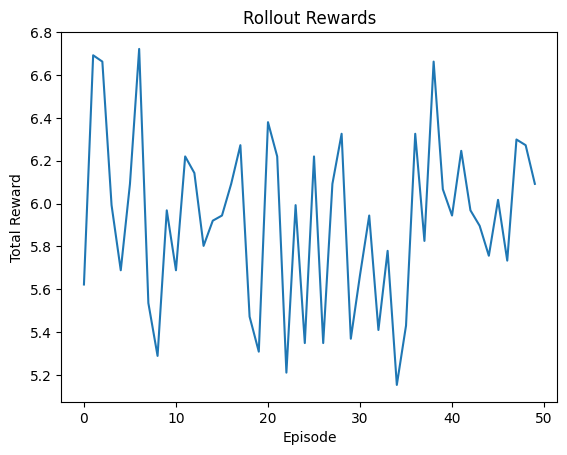

In [17]:
import matplotlib.pyplot as plt

env = gym.make("CarRacing-v2", render_mode='rgb_array')
agent = TransformerOptionAgent((3,96,96), num_skills=10, action_dim=3)
rewards = []
for ep in range(50):
    r = rollout_episode(env, agent)
    rewards.append(r)
    print(f"Episode {ep}: Total Reward: {r}")

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rollout Rewards')
plt.show()

## Next Steps

### Critic + Value Heads

In [18]:
class Critic(nn.Module):
    def __init__(self, input_dim, skill_dim):
        super().__init__()
        self.q1 = nn.Sequential(
            nn.Linear(input_dim+skill_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.q2 = nn.Sequential(
            nn.Linear(input_dim+skill_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x, skill, action):
        x = torch.cat([x, skill, action], dim=-1)
        return self.q1(x), self.q2(x)

### Learn skill Transitions via Entropy or Mutual Information
Instead of assuming skill transitions are fixed, we make the skill selector learn:
- Low entropy over short spans (temporal coherence)
- High entropy over long spans (diversity)

use intrinsic reward:
$$r_{intrinsic} = \log D(z|s) - \log p(z)$$
where:
- $D(z|s)$ is the discriminator probability of skill given state
- $p(z)$ is the prior distribution over skills

### Replace Skill IDs with Continuous Latent Skills (DADS/VALOR)
Discrete skills become:
$$z_t \in \mathbb{R}^d, z_t \sim p(z|h_{1:t-1})$$


In [76]:
class SkillGenerator(nn.Module):
    def __init__(self, latent_dim, skill_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, skill_dim)
        )

    def forward(self, state_feat):
        return self.fc(state_feat)
# z = p(z|f(s))

In [77]:
class TransformerPolicy(nn.Module):
    def __init__(self, input_dim, skill_dim, action_dim, seq_len, nhead=4, nlayers = 2):
        super().__init__()
        self.input_proj = nn.Linear(input_dim+skill_dim, input_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)

        self.action_head = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Tanh()
        )
    def forward(self, x, skill_embeddings):
        x = torch.cat([x, skill_embeddings], dim=-1)
        x = self.input_proj(x)
        x = x.permute(1,0,2)
        out = self.transformer(x)
        final_token = out[-1]
        action = self.action_head(final_token), final_token
        return action

In [78]:
#Discriminator for MI rewards
class SkillDiscriminator(nn.Module):
    def __init__(self, state_dim, skill_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128,skill_dim)
        )

    def forward(self, state_feat):
        return self.fc(state_feat)

In [79]:
class TransformerOptionAgent:
    def __init__(self, image_shape, action_dim, latent_dim=64, skill_dim=16, seq_len=10):
        self.encoder = ConvEncoder(image_shape, latent_dim)
        self.skill_generator = SkillGenerator(latent_dim, skill_dim)

        self.policy = TransformerPolicy(latent_dim, skill_dim, action_dim, seq_len)
        self.critic = Critic(latent_dim, skill_dim)
        self.target_critic = Critic(latent_dim, skill_dim)
        self.target_critic.load_state_dict(self.critic.state_dict())

        self.discriminator = SkillDiscriminator(latent_dim, skill_dim)

        self.opt_policy = optim.Adam(self.policy.parameters(), lr=3e-4)
        self.opt_critic = optim.Adam(self.critic.parameters(), lr=3e-4)
        self.opt_disc = optim.Adam(self.discriminator.parameters(), lr=3e-4)

        self.seq_len = seq_len
        self.gamma = 0.99
        self.tau = 0.005
        self.alpha = .2

    def compute_intrinsic_reward(self, state_feat, skill):
        logits = self.discriminator(state_feat)
        log_probs = F.log_softmax(logits, dim=-1)
        prior = torch.log(torch.tensor(1.0 / logits.shape[-1]))
        return (log_probs - skill).sum(dim=-1) - prior

In [80]:
def update_sac(agent, state_seq, skill_seq, actions, rewards, next_state_seq, skill_seq_next, dones):
    rewards = rewards.unsqueeze(1)
    dones = dones.unsqueeze(1)

    with torch.no_grad():
        next_action,next_feat = agent.policy(next_state_seq, skill_seq_next)
        q1_next, q2_next = agent.target_critic(next_feat, next_action)
        target_q = torch.min(q1_next, q2_next)
        target_val = rewards + (1-dones) * agent.gamma * target_q

    with torch.no_grad():
        _, curr_feat = agent.policy(state_seq, skill_seq)

    q1,q2 = agent.critic(state_seq, skill_seq, actions)
    critic_loss = F.mse_loss(q1, target_val) + F.mse_loss(q2, target_val)

    agent.opt_critic.zero_grad()
    critic_loss.backward()
    agent.opt_critic.step()

    new_action, state_feat = agent.policy(state_seq, skill_seq)
    q1,q2 = agent.critic(state_seq, skill_seq, new_action)
    min_q = torch.min(q1,q2)

    log_pi = torch.log_softmax(new_action, dim=-1)
    policy_loss = (agent.alpha * log_pi - min_q).mean()
    agent.opt_policy.zero_grad()
    policy_loss.backward()
    agent.opt_policy.step()

    with torch.no_grad():
        for p, tp in zip(agent.critic.parameters(), agent.target_critic.parameters()):
            tp.data.mul_(1 - agent.tau)
            tp.data.add_(agent.tau * p.data)

    return critic_loss.item(), policy_loss.item()

In [81]:
def update_discriminator(agent, state_feats, skill_vectors):
    logits = agent.discriminator(state_feats)
    labels = skill_vectors.detach()
    loss = F.mse_loss(logits, labels)

    agent.opt_disc.zero_grad()
    loss.backward()
    agent.opt_disc.step()
    return loss.item()

In [82]:
from collections import deque
agent = TransformerOptionAgent((3,96,96), action_dim = env.action_space.shape[0], latent_dim=64, skill_dim=16, seq_len=10)
replay_buffer = deque(maxlen=100000)

/home/fede/miniconda3/envs/procgen/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [83]:
def preprocess(obs):
    return torch.tensor(obs, dtype=torch.float32).permute(2,0,1)

In [96]:
def collect_eps(env, agent, seq_len=10):

    obs, _ = env.reset()
    done = False
    ep_reward = 0
    obs_seq, skill_seq = [],[]

    buffer = []

    while not done:
        obs_tensor = preprocess(obs)
        feat = agent.encoder(obs_tensor.unsqueeze(0)).squeeze(0)
        skill = agent.skill_generator(feat)

        obs_seq.append(obs_tensor) 
        skill_seq.append(skill.squeeze(0))

        if len(obs_seq) < seq_len:
            action = env.action_space.sample()
        else:
            # Encode observation sequence
            x_seq = torch.stack(obs_seq[-seq_len:])  # (T, C, H, W)
            x_seq_encoded = agent.encoder(x_seq)   # (1, T, latent_dim)

            # Skills must be stacked and reshaped
            s_seq = torch.stack(skill_seq[-seq_len:])  # (T, latent_dim)
            s_seq = s_seq.unsqueeze(0)                            # (1, T, latent_dim)

            # Forward pass
            x_seq_encoded = x_seq_encoded.unsqueeze(0)   # (1, T, latent_dim)
            action,_ = agent.policy(x_seq_encoded, s_seq)        # Output: (1, A)
            action = action.squeeze(0).cpu().detach().numpy()

        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        ep_reward += reward

        buffer.append((obs,action, reward, next_obs, float(done)))

        obs = next_obs

    for i in range(len(buffer)-seq_len):
        traj = buffer[i:i+seq_len+1]
        obs_seq = [preprocess(x[0]) for x in traj[:-1]]
        next_obs_seq = [preprocess(x[3]) for x in traj[1:]]
        act_seq = torch.tensor([x[1] for x in traj[:-1]], dtype=torch.float32)
        reward_seq = torch.tensor([x[2] for x in traj[:-1]], dtype=torch.float32)
        done_seq = torch.tensor([x[4] for x in traj[:-1]], dtype=torch.float32)

        replay_buffer.append((obs_seq, act_seq, reward_seq, next_obs_seq, done_seq))
    return ep_reward

In [97]:
import random
def sample_batch(buffer, batch_size, seq_len):
    batch = random.sample(buffer, batch_size)
    obs_seq, act_seq, rew_seq, next_obs_seq, done_seq = zip(*batch)

    obs_seq = [torch.stack(x) for x in obs_seq]
    next_obs_seq = [torch.stack(x) for x in next_obs_seq]

    obs_batch = torch.stack(obs_seq)
    next_obs_batch = torch.stack(next_obs_seq)
    act_batch = torch.stack(act_seq)
    rew_batch = torch.stack(rew_seq)
    done_batch = torch.stack(done_seq)

    return obs_batch, act_batch, rew_batch, next_obs_batch, done_batch

In [98]:
def train_Step(agent, buffer, batch_size=32):
    obs_batch, act_batch, rew_batch, next_obs_batch, done_batch = sample_batch(buffer, batch_size, agent.seq_len)

    with torch.no_grad():
        feat_batch = agent.encoder(obs_batch.view(-1, 3, 96, 96).view(batch_size, agent.seq_len, -1))
        next_feat_batch = agent.encoder(next_obs_batch.view(-1, 3, 96, 96).view(batch_size, agent.seq_len, -1))

    skill_seq = agent.skill_generator(feat_batch[:, -1]).unsqueeze(1).expand(-1, agent.seq_len, -1)
    skill_seq_next = agent.skill_generator(next_feat_batch[:, -1]).unsqueeze(1).expand(-1, agent.seq_len, -1)

    critic_loss, actor_loss = update_sac(agent, feat_batch, skill_seq, act_batch, rew_batch, next_feat_batch, skill_seq_next, done_batch)
    with torch.no_grad():
        skill_targets = skill_seq[:, -1]  # most recent skill

    disc_input = feat_batch[:, -1]
    disc_loss = update_discriminator(agent, disc_input, skill_targets)
    return critic_loss, actor_loss

In [ ]:
rewards = []
for ep in range(100):
    r = collect_eps(env, agent)
    rewards.append(r)

    if len(replay_buffer)> 500:
        for _ in range(10):
            critic_loss, actor_loss = train_Step(agent, replay_buffer, batch_size=32)
    print(f"Episode {ep}: Total Reward: {r}, Critic Loss: {critic_loss:.4f}, Actor Loss: {actor_loss:.4f}")

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rollout Rewards')
plt.grid()
plt.show()
